In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from math import exp
import random
import re
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from functions import *
import os
import requests

In [2]:
def apply_mutations(seq, mut_list):
    mut_seq = seq
    for mut in mut_list:
        ind = int(mut[1:-1])-1
        new = mut[-1].upper()
        temp_list = list(mut_seq)
        temp_list[ind] = new
        mut_seq = ''.join(temp_list)
    return mut_seq

# Topt: dataset split

In [2]:
topt_data = pd.read_csv('../data/Topt/sequence_ogt_topt.csv') # obtained from TOMER (https://doi.org/10.1021/acs.jcim.0c00489)
topt_data = topt_data[['uniprot_id','topt','sequence']]

In [3]:
def split_table( table, ratio ):
    idx=list(table.index)
    np.random.shuffle(idx)
    num_split = int( len(idx) * ratio)
    idx_test, idx_train = idx[:num_split], idx[num_split:]
    train_table = (table.iloc[idx_train]).reset_index().drop(['index'],axis=1)
    test_table = (table.iloc[idx_test]).reset_index().drop(['index'],axis=1)
    return train_table,test_table

In [7]:
train, test = split_table(topt_data, ratio=0.1)

In [8]:
# train.to_csv('../data/train.csv',index=None)
# test.to_csv('../data/test.csv',index=None)

In [10]:
# fig, axs = plt.subplots(1,2, figsize=(10,4))
# axs[0].hist(train['topt'])
# axs[1].hist(test['topt'])

In [8]:
train = pd.read_csv('../data/Topt/train.csv'); test=pd.read_csv('../data/Topt/test.csv');

In [9]:
# Oversampling for T >= 80 C
# train_os = train.copy()
# high_ot = (train[train['topt']>=80]).reset_index().drop(['index'],axis=1)
# over_high = []
# for i in range( len(high_ot.index) ):
#     rand_idx = np.random.randint( len( high_ot.index ) - 1,size=1)[0]
#     temp_data = dict( high_ot.iloc[rand_idx] )
#     over_high.append( temp_data )
# over_pd = pd.DataFrame(over_high)
# train_os = ( pd.concat([ train_os, over_pd]) ).reset_index().drop(['index'],axis=1)
# train_os.to_csv('../data/train_os.csv',index=None)

In [10]:
train_os = pd.read_csv('../data/Topt/train_os.csv')

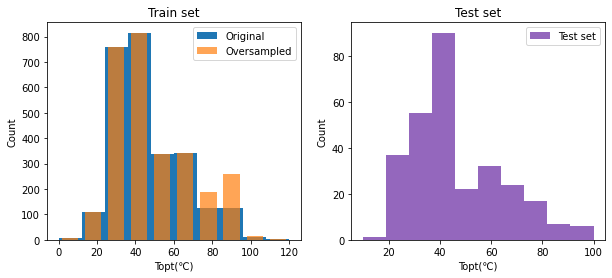

In [11]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(train['topt'],alpha=1,label='Original');
axs[0].hist(train_os['topt'],alpha=0.7, histtype='barstacked',rwidth=0.7, label='Oversampled')
axs[0].set_title('Train set')
axs[1].hist(test['topt'], bins=10, color='tab:purple', label='Test set');
axs[1].set_title('Test set')
for ax in axs:
    ax.set_xlabel('Topt(\u2103)')
    ax.set_ylabel('Count')
    ax.legend()

In [22]:
print(len(train_os.index))
print(len(test.index))

2829
291


In [2]:
topt_data = pd.read_csv('../data/Topt/sequence_ogt_topt.csv') 
topt_data.head()

,Unnamed: 0,uniprot_id,ogt,topt,sequence
0,0,P43408,85,70.0,MKNKVVVVTGVPGVGGTTLTQKTIEKLKEEGIEYKMVNFGTVMFEV...
1,1,Q89GR3,26,30.0,MNLAIVEAPADSTPPPADPLDHLADALFHEMGSPGVYGRTALYEDV...
2,2,Q60352,80,37.0,MLTILKLGGSILSDKNVPYSIKWDNLERIAMEIKNALDYYKNQNKE...
3,3,Q97X08,74,80.0,MIMNKLYIIIVPIIVIIVVGVIGGAIYLHHQSPNVKTSSITVTTNE...
4,4,Q7B8C4,30,37.0,MTVKKLYFIPAGRCMLDHSSVNSTLTPGNLLNLPVWCYLLETEEGP...


In [86]:
def get_protinfo(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    response = requests.get(url)
    data = response.json()
    if 'organism' in data.keys():
        organism = data['organism']['scientificName'].split('(')[0].strip()
    else:
        organism = 'unknown'
        
    if 'proteinDescription' in data.keys():
        description = data['proteinDescription']
        if 'recommendedName' in description.keys():
            recName_data = data['proteinDescription']['recommendedName']
            if 'ecNumbers' in recName_data.keys():
                ec = recName_data['ecNumbers'][0]['value'].strip()
            elif 'alternativeNames' in description.keys():
                altName_data = data['proteinDescription']['alternativeNames']
                if 'ecNumbers' in altName_data[0].keys():
                    ec = altName_data[0]['ecNumbers'][0]['value'].strip()
                else:
                    ec='unknown'
            else:
                ec='unknown'
        elif 'submissionNames' in description.keys():
            if 'ecNumbers' in data['proteinDescription']['submissionNames'][0].keys():
                ec = data['proteinDescription']['submissionNames'][0]['ecNumbers'][0]['value'].strip()
            else:
                ec='unknown'
    else:
        ec='unknown'
        
    return {'uniprot_id':uniprot_id, 'ec':ec,'organism':organism}

In [87]:
enz_info = []
for prot_id in list(topt_data['uniprot_id']):
    enz_info.append( get_protinfo(prot_id) )

In [89]:
enz_info = []
for prot_id in list(topt_data['uniprot_id']):
    enz_info.append( get_protinfo(prot_id) )
einfo_pd = pd.DataFrame(enz_info)
einfo_pd.to_csv('../data/Topt/topt_enzinfo.csv',index=None)
einfo_pd.head()

,uniprot_id,ec,organism
0,P43408,2.7.4.3,Methanotorris igneus
1,Q89GR3,6.2.1.n2,Bradyrhizobium diazoefficiens
2,Q60352,2.7.4.26,Methanocaldococcus jannaschii
3,Q97X08,3.2.1.4,Saccharolobus solfataricus
4,Q7B8C4,3.1.1.81,Bacillus thuringiensis subsp. darmstadiensis


## prep input for preoptem

In [7]:
test=pd.read_csv('../data/Topt/test.csv');
records = []
for i in range(len(test.index)):
    records.append( SeqRecord( Seq(list(test['sequence'])[i]), 
                              id =list(test['uniprot_id'])[i], description='' ) )
SeqIO.write(records,'../data/test_preoptem.fasta',"fasta")

291

# pHopt

In [3]:
# train_records = SeqIO.parse( '../data/pHopt/phopt_training.fasta' , "fasta")
# val_records = SeqIO.parse( '../data/pHopt/phopt_validation.fasta' , "fasta")
# test_records = SeqIO.parse( '../data/pHopt/phopt_testing.fasta' , "fasta")
# def records_to_table(records):
#     data = []
#     for record in records:
#         temp = {'uniprot_id':str(record.id).strip(),'sequence':str(record.seq)}
#         temp['pHopt'] = float( record.description.split('|')[3] )
#         temp['EC'] = record.description.split('|')[2].strip()
#         temp['Organism'] = record.description.split('|')[1].strip()
#         data.append(temp)
#     table = pd.DataFrame(data)
#     return table

In [4]:
# train_set = records_to_table(train_records)
# val_set = records_to_table(val_records)
# test_set = records_to_table(test_records)
# train_data = pd.concat([train_set, val_set])

In [36]:
# train_data.to_csv('../data/pHopt/train_pH.csv',index=None)
# test_set.to_csv('../data/pHopt/test_pH.csv',index=None)

# Case study: beta-agarase

In [4]:
# betaA = pd.read_csv('../data/casestudy/beta_agarase.csv')
# seqs = []
# for pid in list(betaA['uniprot_id']):
#     seq = get_seq(pid)
#     seqs.append(seq)
# betaA['sequence'] = seqs
# betaA.to_csv('../data/casestudy/beta_agarase.csv',index=None)

# Case study: GDH

In [28]:
# gdh_data = pd.read_csv('../data/casestudy/BcGDH.csv')
# record = list(SeqIO.parse('../data/casestudy/A0A150JSL8.fasta',"fasta"))
# hcgdh_seq = str(record[0].seq)
# seqs = []
# for i in range(len(gdh_data.index)):
#     if list(gdh_data.Mutations)[i]=='WT':
#         seqs.append( hcgdh_seq )
#     else:
#         mut_list = list(gdh_data.Mutations)[i].split('/')
#         mutseq = apply_mutations( hcgdh_seq, mut_list)
#         seqs.append(mutseq)
# gdh_data['sequence'] = seqs
# gdh_data.head()

,Mutations,topt,reference,sequence
0,WT,68.5,https://doi.org/10.1002/pro.3963,MTKIITSPSKFIQGPDELSRLSAYTERLGKKAFIIADDFVTGLVGK...
1,D121N,75.0,https://doi.org/10.1002/pro.3963,MTKIITSPSKFIQGPDELSRLSAYTERLGKKAFIIADDFVTGLVGK...
2,F245S,70.0,https://doi.org/10.1002/pro.3963,MTKIITSPSKFIQGPDELSRLSAYTERLGKKAFIIADDFVTGLVGK...
3,D121N/F245S,60.0,https://doi.org/10.1002/pro.3963,MTKIITSPSKFIQGPDELSRLSAYTERLGKKAFIIADDFVTGLVGK...


In [29]:
# gdh_data.to_csv('../data/casestudy/BcGDH_data.csv',index=None)

# Case study:Xylose isomerase

In [51]:
# xi_data = pd.read_csv('../data/casestudy/XI.csv')
# seq_TT = get_seq('P19148')
# seq_TN = get_seq('P45687')
# seqs = []
# for i in range(len(xi_data.index)):
#     if list(xi_data.mutation)[i] == 'WT':
#         if list(xi_data.organism)[i] =='TT':
#             seqs.append( seq_TT )
#         else:
#             seqs.append( seq_TN )
#     else:
#         mut_list = list(xi_data.mutation)[i].split('/')
#         if list(xi_data.organism)[i] =='TT':
#             seqs.append( apply_mutations( seq_TT, mut_list) )
#         else:
#             seqs.append( apply_mutations( seq_TN, mut_list) )
# xi_data['sequence'] = seqs
# xi_data

,uniprot_id,mutation,organism,topt,note,reference
0,P19148,WT,TT,84,WT,https://doi.org/10.1093/protein/13.4.259
1,P19148,Q59P,TT,84,Gln58Pro,https://doi.org/10.1093/protein/13.4.259
2,P19148,A63P,TT,71,Ala62Pro,https://doi.org/10.1093/protein/13.4.259
3,P19148,Q59P/A63P,TT,73,Gln58Pro/Ala62Pro,https://doi.org/10.1093/protein/13.4.259
4,P45687,WT,TN,97,WT,https://doi.org/10.1093/protein/13.4.259
5,P45687,P59Q,TN,88,Pro58Gln,https://doi.org/10.1093/protein/13.4.259
6,P45687,P63A,TN,88,Pro62Ala,https://doi.org/10.1093/protein/13.4.259
7,P45687,P59Q/P63A,TN,86,Pro58Gln/Pro62Ala,https://doi.org/10.1093/protein/13.4.259


In [56]:
# xi_data.to_csv('../data/casestudy/xi_data.csv',index=None)

# Case study: TrBgl

In [44]:
# trbgl_data = pd.read_csv('../data/casestudy/TrBgl2.csv')
# seq_trbgl = get_seq('O93785')
# seqs = []
# for i in range(len(trbgl_data.index)):
#     if list(trbgl_data.mutation)[i]=='WT':
#         seqs.append( seq_trbgl)
#     else:
#         mut_list = list(trbgl_data.mutation)[i].split('/')
#         mutseq = apply_mutations( seq_trbgl, mut_list)
#         seqs.append( mutseq )
# trbgl_data['sequence'] = seqs

In [46]:
# trbgl_data.to_csv('../data/casestudy/TrBgl_data.csv',index=None)

# Case study: BbrSpase

In [8]:
# bbrspase_data = pd.read_csv('../data/casestudy/BbrSPase.csv')
# seq_spase = get_seq('A0AAI7ZJW1')
# seqs = []
# for i in range(len(bbrspase_data.index)):
#     if list(bbrspase_data.mutation)[i]=='WT':
#         seqs.append( seq_spase)
#     else:
#         mut_list = list(bbrspase_data.mutation)[i].split('/')
#         mutseq = apply_mutations( seq_spase, mut_list)
#         seqs.append( mutseq )
# bbrspase_data['sequence'] = seqs

In [9]:
bbrspase_data

,uniprot_id,organism,mutation,topt,reference,sequence
0,A0AAI7ZJW1,Bifidobacterium breve,WT,50,https://doi.org/10.1007/s00253-022-12030-w,MKNKVQLIAYADRLGDGTLSSMTDILRTRFDGVYDGVHVLPFFTPF...
1,A0AAI7ZJW1,Bifidobacterium breve,P134C/L343F,45,https://doi.org/10.1007/s00253-022-12030-w,MKNKVQLIAYADRLGDGTLSSMTDILRTRFDGVYDGVHVLPFFTPF...
2,A0AAI7ZJW1,Bifidobacterium breve,L341V/L343F,55,https://doi.org/10.1007/s00253-022-12030-w,MKNKVQLIAYADRLGDGTLSSMTDILRTRFDGVYDGVHVLPFFTPF...
3,A0AAI7ZJW1,Bifidobacterium breve,P134C/L341V/L343F,50,https://doi.org/10.1007/s00253-022-12030-w,MKNKVQLIAYADRLGDGTLSSMTDILRTRFDGVYDGVHVLPFFTPF...


In [10]:
# bbrspase_data.to_csv('../data/casestudy/bbrspase_data.csv',index=None)

# Default hyperparameters

In [3]:
# default_dict = { 'dim':320,'window':5,'dropout':0.1,'n_head':4,'n_RD':3 }
# dump_pickle( default_dict, '../data/performances/default.pkl')

In [2]:
# win_sizes = [3,5,7]; dropouts = [0.1,0.2,0.5]; ind = 1;
# for win_size in win_sizes:
#     for dp in dropouts:
#         temp_dict = { 'window': win_size,'dropout':dp,'n_head':4,'n_RD': 3 }
#         dump_pickle( temp_dict, '../data/hyparams/params_'+str(ind)+'.pkl')
#         ind +=1